# Siamese Neural Networks
Recognize images of icebergs from images of ships. 
These images were taken from space with a Sentinel-4 satellite. The goal was to create the most accurate neural network to differentiate them. However, neural networks usually only work well with A LOT of data, and I constrained you guys to 1000 examples to train on. That seems like a lot, but a CONVENTIONAL neural network needs more data. However, we are going to make a special kind of neural network: *Siamese Network*. This special network is used for face recognition and few-shot learning(learning from few examples). Let's get started by importing the usual liraries:

In [2]:
from keras.layers import Input, Conv2D, Lambda, merge, Dense, Flatten,MaxPooling2D,Activation, Dropout
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import Adam
from skimage.io import imshow
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

Using TensorFlow backend.


In [3]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load the Data


In [4]:
npz = np.load('/content/drive/My Drive/AI_ML/NMT Internal Lab/input_data.npz')
X_train = npz['X_train']
Y_train = npz['Y_train']
del npz
print ('We have {} examples to work with'.format(Y_train.shape[0]-1000))

We have 3113 examples to work with


## Check the data

Load some of the images to observe how your data look like.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


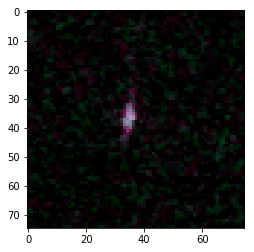

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


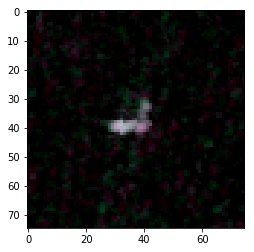

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


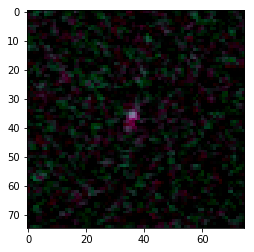

In [5]:
import matplotlib.pyplot as plt
##f, ax = plt.subplots(2,5, figsize=(16,10))
for i in range(0,3):
  plt.imshow(X_train[i])
  ##ax[i//5, i%5].axis('off')
        ##ax[i//8, i%8].set_title(labels[data_sample_labels[i]])
  plt.show()

# Creating the structure of Siamese Network

You just need to break it into some steps:
1. 2 Inputs for each images
2. Creating a network which both images will go through individually
3. Couple the network to each input
4. Calculate the L1 distance between them. Just (x1,y1)-(x2,y2)
5. 1 Added layer that will say 1 if they are the same and 0 if they are different

# Create two Inputs for each image - left_input and right_input
Hint - use Input Function in Keras and keep the shape to be 75,75,3

In [0]:
left_input = Input((75, 75, 3))
right_input = Input((75, 75, 3))

# Create a base Network in which both images will go through individually.

Hint - Use Sequential Model in Keras with convolution layers, Maxpooling Layers, Flatten Layer and Denser Layer with appropriate activation functions.
Name the network as base_network

In [0]:
input_shape=(75, 75, 3)

In [8]:
base_network = Sequential()
base_network.add(Conv2D(64, (10,10), activation='relu', input_shape=input_shape))
base_network.add(MaxPooling2D())
base_network.add(Conv2D(128, (7,7), activation='relu'))
base_network.add(MaxPooling2D())
base_network.add(Conv2D(128, (4,4), activation='relu'))
base_network.add(MaxPooling2D())
base_network.add(Conv2D(256, (4,4), activation='relu'))
base_network.add(Flatten())
base_network.add(Dense(4096, activation='sigmoid'))




Instructions for updating:
Colocations handled automatically by placer.


# Process the left and right inputs to the same Base Network(base_network)

In [0]:
encoded_l = base_network(left_input)
encoded_r = base_network(right_input)

# Get the L1 Distance layer between the 2 processed encodings (processed_a and processed_b)
Hint - You can use Lambda function for this.

In [0]:
L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
L1_distance = L1_layer([encoded_l, encoded_r])

# Add the prediction layer in the end and create the Siamese Network using Model function.

In [0]:
prediction = Dense(1,activation='sigmoid')(L1_distance)

In [0]:
base_network = Model(inputs=[left_input,right_input],outputs=prediction)

# Define the Optimizer Adam and Compile the Siamese Model.

In [0]:
optimizer = Adam(lr = 0.00006)
base_network.compile(loss="binary_crossentropy",optimizer=optimizer)

# Show the Summary of your Siamese Network

In [14]:
base_network.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 75, 75, 3)    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 75, 75, 3)    0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 4096)         5406016     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 4096)         0           sequential_1[1][0]               
          

# Creating the Pair of Images to train on

It's not time to train though. We still have to create pairs of images to train on. There will be Positive(the same class) or Negative(different classes) for outputs. Let's construct this dataset. It is recommended that there are equal amounts positive and negative.

In [0]:
# First let's separate the dataset from 1 matrix to a list of matricies
image_list = np.split(X_train[:1000],1000)
label_list = np.split(Y_train[:1000],1000)

left_input = []
right_input = []
targets = []

#Number of pairs per image
pairs = 5
#Let's create the new dataset to train on
for i in range(len(label_list)):
    for _ in range(pairs):
        compare_to = i
        while compare_to == i: #Make sure it's not comparing to itself
            compare_to = random.randint(0,999)
        left_input.append(image_list[i])
        right_input.append(image_list[compare_to])
        if label_list[i] == label_list[compare_to]:# They are the same
            targets.append(1.)
        else:# Not the same
            targets.append(0.)
            
left_input = np.squeeze(np.array(left_input))
right_input = np.squeeze(np.array(right_input))
targets = np.squeeze(np.array(targets))

iceimage = X_train[101]
test_left = []
test_right = []
test_targets = []

for i in range(Y_train.shape[0]-1000):
    test_left.append(iceimage)
    test_right.append(X_train[i+1000])
    test_targets.append(Y_train[i+1000])

test_left = np.squeeze(np.array(test_left))
test_right = np.squeeze(np.array(test_right))
test_targets = np.squeeze(np.array(test_targets))

Now we have a lot more examples.
Now we have pairs x 1000 examples to train the network on. 
Each side will have an input of an image and the output will be one if they are the same and zero if not.

# Train the Siamese train on left and right input image pairs created and validate it by test pairs.

In [0]:
from sklearn.utils import shuffle
targets, test_image, support_set = shuffle(targets, left_input, right_input)
pairs = [left_input, right_input]

In [0]:
test_targets, test_image, support_set = shuffle(test_targets, test_left, test_right)
test_pairs = [left_input, right_input]

In [0]:
  def test_oneshot(model, N, k,inputs,targets,verbose = 0):
    """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
    n_correct = 0
    if verbose:
        print("Evaluating model on {} random {} way one-shot learning tasks ... \n".format(k,N))
    for i in range(k):
        probs = model.predict(inputs)
        if np.argmax(probs) == np.argmax(targets):
            n_correct+=1
    percent_correct = (100.0 * n_correct / k)
    if verbose:
        print("Got an average of {}% {} way one-shot learning accuracy \n".format(percent_correct,N))
    return percent_correct

In [0]:
import time
evaluate_every = 10 # interval for evaluating on one-shot tasks
loss_every = 20 # interval for printing loss (iterations)
batch_size = 32
n_iter = 20000
N_way = 20 # how many classes for testing one-shot tasks>
n_val = 250 # how many one-shot tasks to validate on?
best = -1
print("Starting training process!")
print("-------------------------------------")
t_start = time.time()
for i in range(1, n_iter):
    loss=base_network.train_on_batch(pairs,targets)
    print("\n ------------- \n")
    print("Loss: {0}".format(loss)) 
    if i % evaluate_every == 0:
        print("Time for {0} iterations: {1}".format(i, time.time()-t_start))
        val_acc = test_oneshot(base_nbase_networketwork,N_way,n_val,pairs,targets,verbose=True)
        if val_acc >= best:
            print("Current best: {0}, previous best: {1}".format(val_acc, best))
            print("Saving weights to: {0} \n".format(weights_path))
            model.save_weights(weights_path_2)
            best=val_acc
    
    if i % loss_every == 0:
        print("iteration {}, training loss: {:.2f},".format(i,loss))

Starting training process!
-------------------------------------
Instructions for updating:
Use tf.cast instead.


In [0]:
def nearest_neighbour_correct(pairs,targets):
    """returns 1 if nearest neighbour gets the correct answer for a one-shot task
        given by (pairs, targets)"""
    L2_distances = np.zeros_like(targets)
    for i in range(len(targets)):
        L2_distances[i] = np.sum(np.sqrt(pairs[0][i]**2 - pairs[1][i]**2))
    if np.argmin(L2_distances) == np.argmax(targets):
        return 1
    return 0


def test_nn_accuracy(N_ways,n_trials,pairs,targets):
    """Returns accuracy of one shot """
    print("Evaluating nearest neighbour on {} unique {} way one-shot learning tasks ...".format(n_trials,N_ways))

    n_right = 0
    
    for i in range(n_trials):
        correct = nearest_neighbour_correct(pairs,targets)
        n_right += correct
    return 100.0 * n_right / n_trials


ways = np.arange(1, 30, 2)
resume =  False
val_accs, train_accs,nn_accs = [], [], []
trials = 450
for N in ways:
    val_accs.append(test_oneshot(base_network, N,trials, test_pairs,test_targets, verbose=True))
    train_accs.append(test_oneshot(base_network, N,trials, pairs,targets, verbose=True))
    nn_accs.append(test_nn_accuracy(N,trials,  test_pairs,test_targets,))
    
#plot the accuracy vs num categories for each
plt.plot(ways, val_accs, "m")
plt.plot(ways, train_accs, "y")
plt.plot(ways, nn_accs, "c")

plt.plot(ways,100.0/ways,"r")
plt.show()